In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [198]:
dataset_path = './weatherHistory.csv'

data = pd.read_csv(dataset_path)
df = pd.DataFrame(data)

TEMP = 'Temperature (C)'
df.columns.to_list()

['Formatted Date',
 'Summary',
 'Precip Type',
 'Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)',
 'Daily Summary']

In [199]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])
df = df.sort_values("Formatted Date")
df = df[(df['Formatted Date'] >= pd.to_datetime('2010-03-01 00:00:00+01:00')) & (df['Formatted Date'] <= pd.to_datetime('2010-06-01 00:00:00+01:00'))]
df = df.loc[:, ['Formatted Date', TEMP]]
df.set_index('Formatted Date', inplace=True)
df.columns=['Value']


In [200]:
df

,Value
Formatted Date,
2010-03-01 00:00:00+01:00,6.094444
2010-03-01 01:00:00+01:00,3.316667
2010-03-01 02:00:00+01:00,6.233333
2010-03-01 03:00:00+01:00,5.727778
2010-03-01 04:00:00+01:00,6.638889
...,...
2010-05-31 21:00:00+02:00,12.711111
2010-05-31 22:00:00+02:00,12.688889
2010-05-31 23:00:00+02:00,12.100000


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

 AR(Autoregressive) отвечает за авторегрессию и описывает зависимость текущего значения временного ряда от его предыдущих значений. Чем выше порядок AR, тем больше предыдущих значений используется для прогнозирования текущего значения

In [201]:
def AR(p,df):
  df_temp = df

  #Генерация лаговых значений (предыдущих значений) на p шагов назад
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.7 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #обучаем линейный регрессор на обучающем наборе данных.
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  
  lr.fit(X_train,y_train)

  # получаем коэффициенты регрессии и пересечения
  theta  = lr.coef_.T
  intercept = lr.intercept_
  
  # Предсказание значений для обучающего набора данных
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

  # Предсказание значений для тестового набора данных
  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

  #Считаем RMSE для тестовых данных
  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

MA(Moving Average) отвечает за скользящее среднее и описывает зависимость текущего значения временного ряда от предыдущих ошибок прогнозирования. Чем выше порядок MA, тем больше предыдущих ошибок учитывается при прогнозировании текущего значения.

q - сколько предыдущих ошибок прогнозирования необходимо учитывать при прогнозировании текущего значения временного ряда

In [202]:
def MA(q,res):

  # Генерация сдвинутых значений остатков модели
  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.7 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  #Сдвинутые значения остатков
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  #Текущие значения остатков
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  #обучаем линейный регрессор на обучающем наборе данных.
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  #Получаем параметры модели
  theta  = lr.coef_.T
  intercept = lr.intercept_
  
  #Предсказываем значения остатков на обучающем наборе 
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  
  #Предсказываем значения остатков на тестовом наборе 
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



Тестируем временной ряд на стационарность с использованием расширенного теста Дики-Фуллера (Augmented Dickey-Fuller Test, ADF).

Критерий Дики-Фуллера (Dickey-Fuller test) - это статистический тест на проверку наличия единичного корня во временном ряде. Единичный корень указывает на то, что временной ряд содержит единичные корни, что, в свою очередь, означает, что временной ряд является нестационарным. Следовательно он имеет тенденцию к изменению со временем и не обладает постоянным средним или дисперсией. В стационарном временном ряде характеристики, такие как среднее значение и дисперсия, остаются постоянными со временем

In [203]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    #тест на стационарность (проверяем гипотезу о наличии единичного корня во временном ряде) 
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
Пилим модель ARIMA на 3 этапа:

1. Стационаризация данных путем дифференцирования (I)
2. Обучаем AR model. (AR)
3. Обучаем MA modelна остатках. (MA)
4. Возвращаем исходные данных

</h1>

#Step 1 : Стационаризация данных

Для того чтобы сделать данные стационарными, логарифмируем данные и используем разность. Дополнительный diff(24) удаляет сезонность.

In [204]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(24))
df_testing.replace([np.inf, -np.inf], np.nan, inplace=True)
adf_check((df_testing.Value.dropna()))

/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.021170183896428
p-value : 2.0744437352740836e-12
Number of Lags Used : 26
Number of Observations Used : 1993
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Formatted Date'>

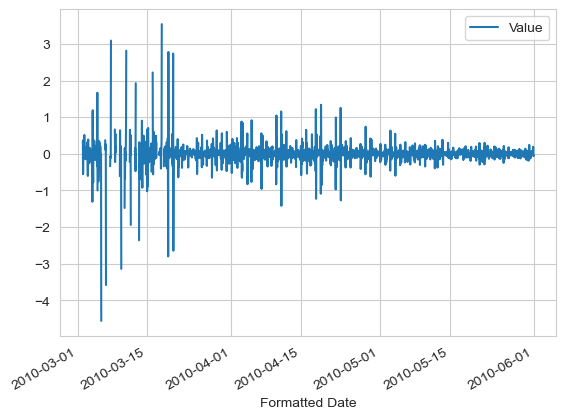

In [205]:
# print(df_testing.to_string())
df_testing.plot()

Строим автокорреляционную функции (ACF) и частную автокорреляционную функцию (PACF) временного ряда

ACF измеряет корреляцию между текущим значением временного ряда и его предыдущими значениями на разных лагах времени.
Для каждого лага автокорреляционная функция показывает, насколько сильно текущее значение коррелирует с предыдущими значениями временного ряда на данном лаге.
График ACF помогает определить наличие сезонности и корреляционных зависимостей в данных. Если ACF значительно отличается от нуля на некоторых лагах, это может указывать на наличие сезонности или тренда в данных.

Функция автокорреляции (АКФ). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов. Функция частной автокорреляции (ЧАКФ). При лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов, считая значения интервалов в промежутке.


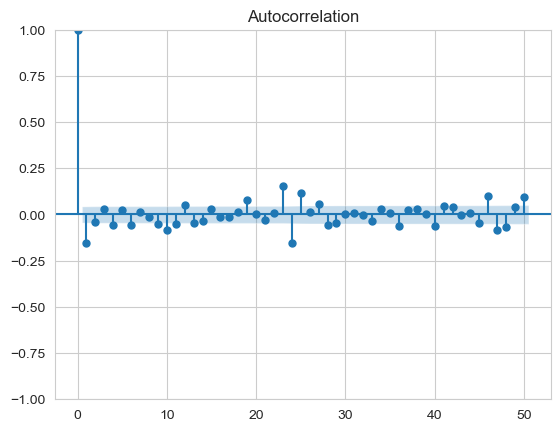

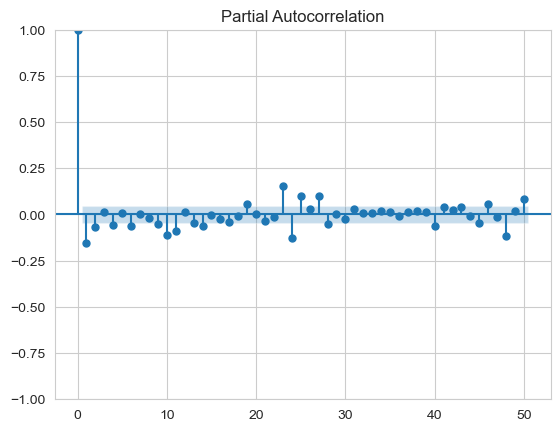

In [206]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

#Step 2 : Обучаем AR model

Мы вычисляем ошибку на тестовом наборе для каждого p и выбираем лучший.

In [207]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.09219691548810584 , Value of p :  1
The RMSE is : 0.0927565037657575 , Value of p :  2
The RMSE is : 0.09290163101983362 , Value of p :  3
The RMSE is : 0.09328125183860715 , Value of p :  4
The RMSE is : 0.0927952485216151 , Value of p :  5
The RMSE is : 0.09281595265033644 , Value of p :  6
The RMSE is : 0.09278819675894553 , Value of p :  7
The RMSE is : 0.09293172183634091 , Value of p :  8
The RMSE is : 0.09286212696368401 , Value of p :  9
The RMSE is : 0.09289265231198374 , Value of p :  10
The RMSE is : 0.0925150534343502 , Value of p :  11
The RMSE is : 0.0920898287727815 , Value of p :  12
The RMSE is : 0.09205383643095366 , Value of p :  13
The RMSE is : 0.09194548895469641 , Value of p :  14
The RMSE is : 0.09208477756514902 , Value of p :  15
The RMSE is : 0.09211497340209622 , Value of p :  16
The RMSE is : 0.09172387952359287 , Value of p :  17
The RMSE is : 0.0918731578333285 , Value of p :  18
The RMSE is : 0.0917745636876863 , Value of p :  19
The RMSE

In [208]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.09167218403722545 , Value of p :  20


<Axes: xlabel='Formatted Date'>

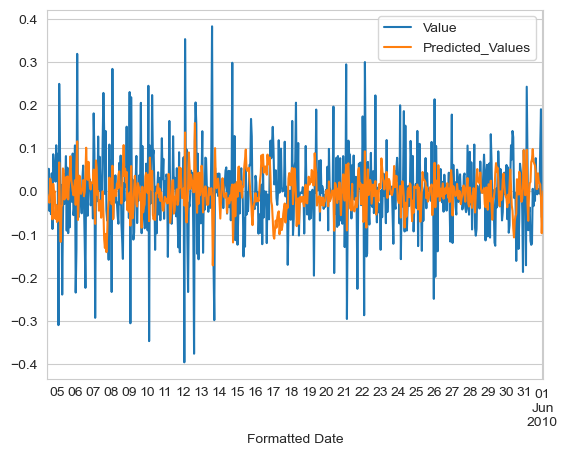

In [209]:
df_c = pd.concat([df_test])
df_c[['Value','Predicted_Values']].plot()

 Получаем остатки для модели MA

In [210]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [211]:
res

,Residuals
Formatted Date,
2010-05-04 11:00:00+02:00,-0.010540
2010-05-04 12:00:00+02:00,0.018645
2010-05-04 13:00:00+02:00,0.074259
2010-05-04 14:00:00+02:00,-0.019272
2010-05-04 15:00:00+02:00,-0.036526
...,...
2010-05-31 21:00:00+02:00,0.085120
2010-05-31 22:00:00+02:00,0.206797
2010-05-31 23:00:00+02:00,0.037613


Визуально оцениваем форму распределения данных
Оценка плотности ядра (kernel density estimation, KDE) для распределения данных временного ряда res

<Axes: ylabel='Density'>

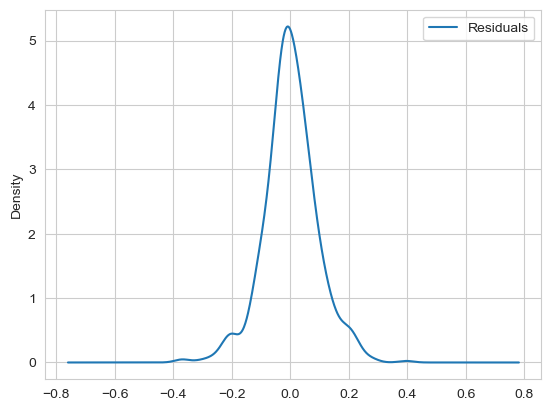

In [212]:
res.plot(kind='kde')

#Step 3 : Обучаем MA model на остатках.

The RMSE is : 0.07563545306730887 , Value of q :  1
The RMSE is : 0.07492030369327561 , Value of q :  2
The RMSE is : 0.07483985241144236 , Value of q :  3
The RMSE is : 0.0749663835028439 , Value of q :  4
The RMSE is : 0.0754014538648518 , Value of q :  5
The RMSE is : 0.0758356596155017 , Value of q :  6
The RMSE is : 0.07588584157428044 , Value of q :  7
The RMSE is : 0.0758210459595966 , Value of q :  8
The RMSE is : 0.07663330147366894 , Value of q :  9
The RMSE is : 0.07694480196172632 , Value of q :  10
The RMSE is : 0.07702483906811268 , Value of q :  11
The RMSE is : 0.07711761317196343 , Value of q :  12
3


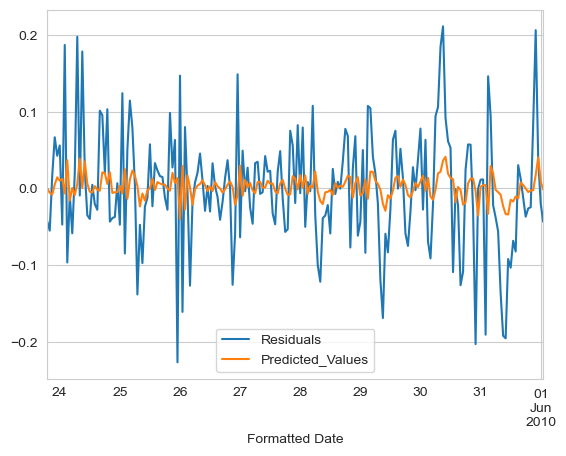

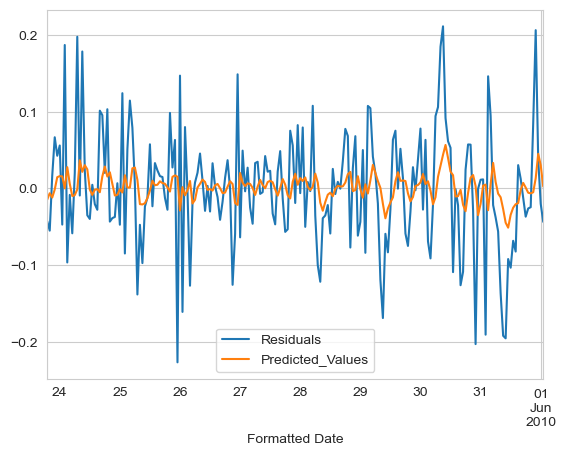

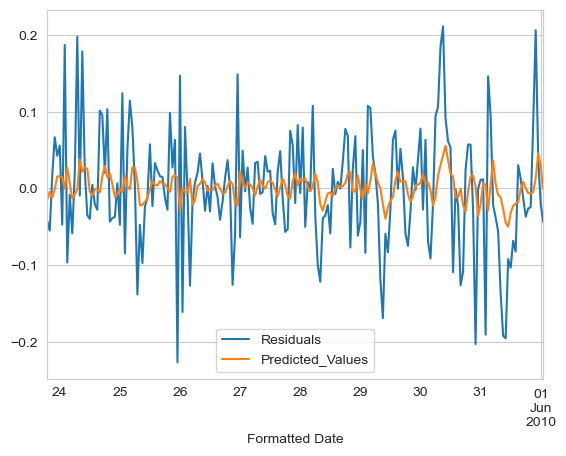

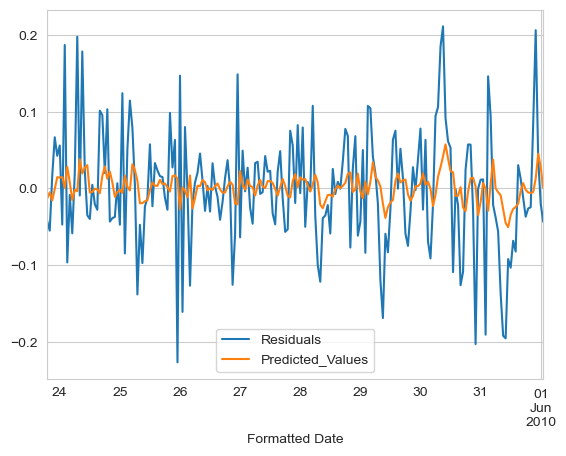

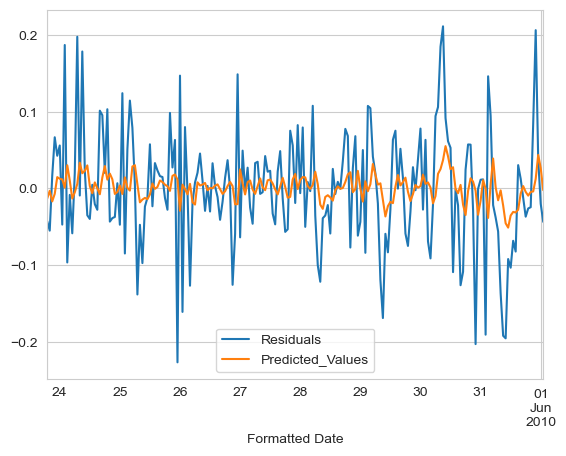

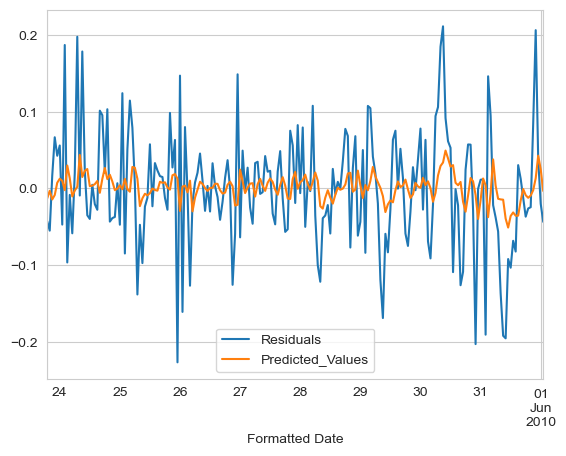

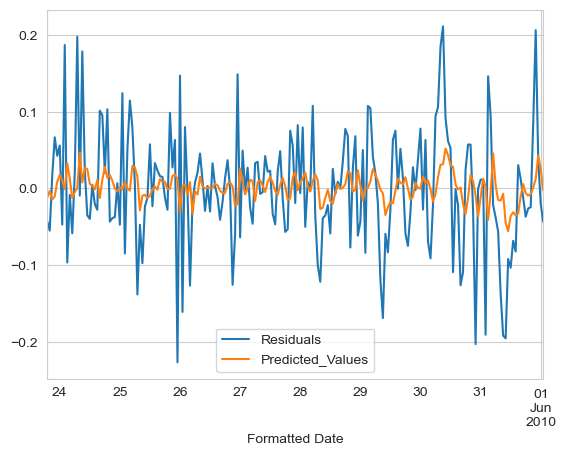

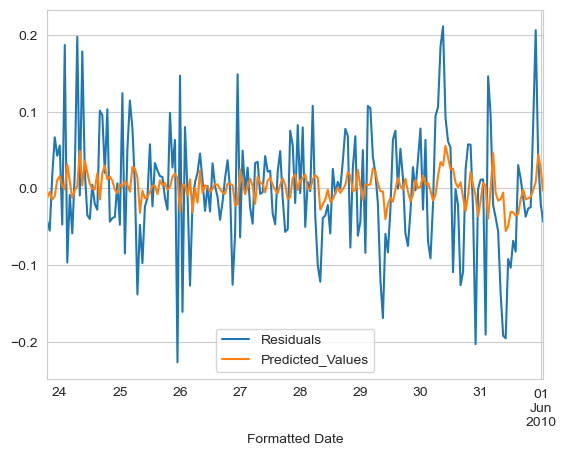

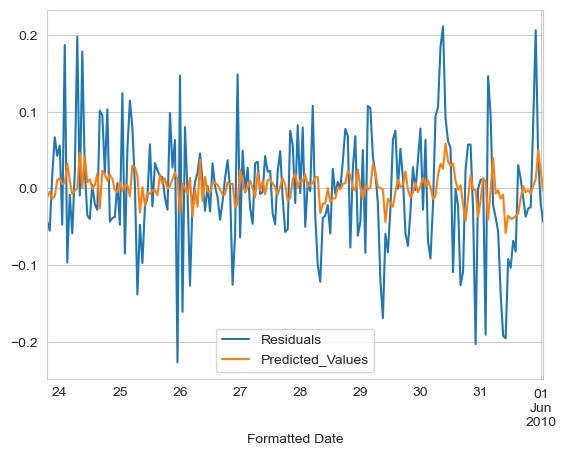

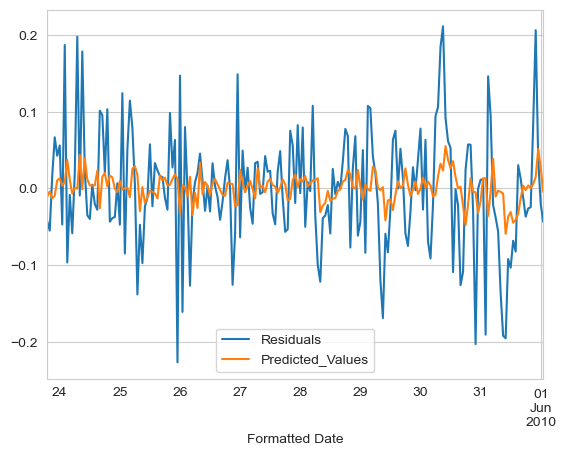

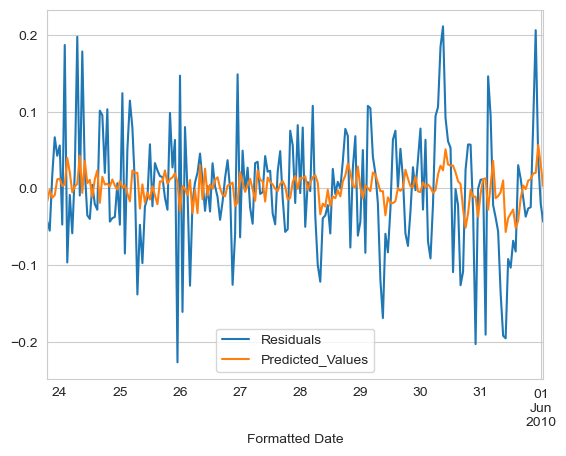

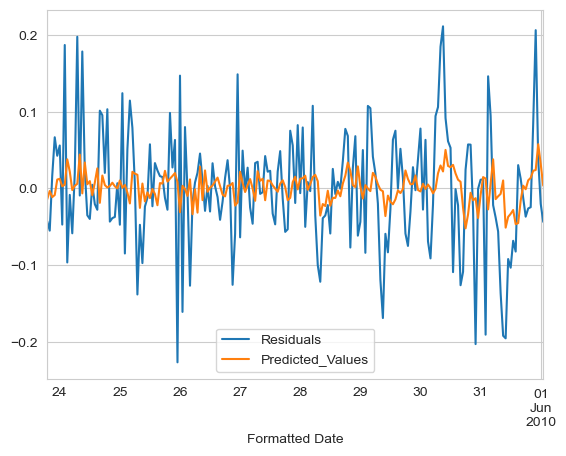

In [213]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 0.07483985241144236 , Value of q :  3
[[ 0.16665866]
 [ 0.11052954]
 [-0.01560184]]
[0.00176976]


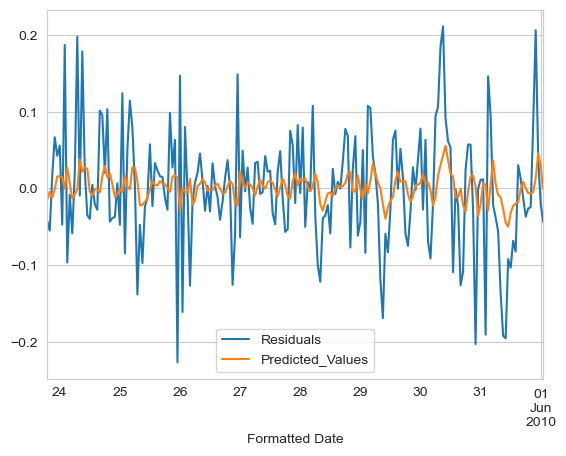

In [214]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [215]:
res_c = pd.concat([res_train,res_test])

In [216]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Predicted_Values
Formatted Date,,,,,
2010-05-04 14:00:00+02:00,-0.019272,0.074259,0.018645,-0.010540,0.016371
2010-05-04 15:00:00+02:00,-0.036526,-0.019272,0.074259,0.018645,0.006475
2010-05-04 16:00:00+02:00,-0.072678,-0.036526,-0.019272,0.074259,-0.007606
2010-05-04 17:00:00+02:00,0.039222,-0.072678,-0.036526,-0.019272,-0.014079
2010-05-04 18:00:00+02:00,-0.022272,0.039222,-0.072678,-0.036526,0.000843
...,...,...,...,...,...
2010-05-31 21:00:00+02:00,0.085120,-0.024451,-0.026127,-0.036846,-0.004618
2010-05-31 22:00:00+02:00,0.206797,0.085120,-0.024451,-0.026127,0.013661
2010-05-31 23:00:00+02:00,0.037613,0.206797,0.085120,-0.024451,0.046024


In [217]:
df_c.Predicted_Values += res_c.Predicted_Values

<Axes: xlabel='Formatted Date'>

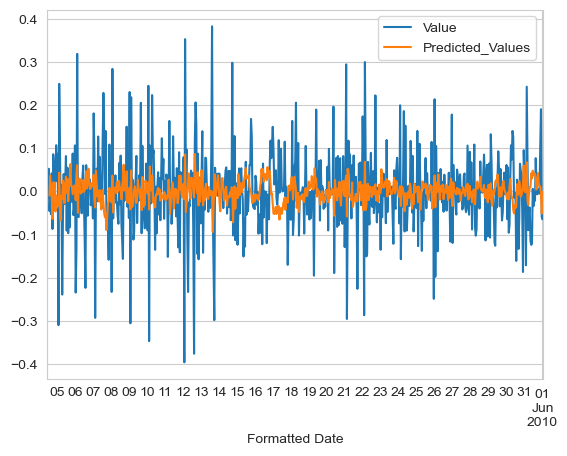

In [218]:
df_c[['Value','Predicted_Values']].plot()

# Step 4 : Возвращаем исходные данных

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [219]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(24).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(24).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/khumachbayramova/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/khumachbayramova/anaconda3/lib/python3.11/site-pac

In [220]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,...,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Shifted_values_17,Shifted_values_18,Shifted_values_19,Shifted_values_20,Predicted_Values
Formatted Date,,,,,,,,,,,,,,,,,,,,,
2010-05-04 11:00:00+02:00,22.744444,-0.125513,0.056178,0.022157,0.174723,0.093199,0.066979,-0.009814,-0.596846,0.545885,...,-0.101733,-0.019261,-0.056788,-0.022142,-0.059628,0.038883,-0.038524,-0.002679,-0.015420,NaN
2010-05-04 12:00:00+02:00,22.933333,-0.016975,-0.125513,0.056178,0.022157,0.174723,0.093199,0.066979,-0.009814,-0.596846,...,-0.087410,-0.101733,-0.019261,-0.056788,-0.022142,-0.059628,0.038883,-0.038524,-0.002679,NaN
2010-05-04 13:00:00+02:00,25.050000,0.000514,-0.016975,-0.125513,0.056178,0.022157,0.174723,0.093199,0.066979,-0.009814,...,-0.028821,-0.087410,-0.101733,-0.019261,-0.056788,-0.022142,-0.059628,0.038883,-0.038524,NaN
2010-05-04 14:00:00+02:00,25.044444,0.052634,0.000514,-0.016975,-0.125513,0.056178,0.022157,0.174723,0.093199,0.066979,...,0.545885,-0.028821,-0.087410,-0.101733,-0.019261,-0.056788,-0.022142,-0.059628,0.038883,25.953195
2010-05-04 15:00:00+02:00,25.100000,-0.045498,0.052634,0.000514,-0.016975,-0.125513,0.056178,0.022157,0.174723,0.093199,...,-0.596846,0.545885,-0.028821,-0.087410,-0.101733,-0.019261,-0.056788,-0.022142,-0.059628,26.202854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-31 21:00:00+02:00,12.711111,-0.005128,-0.002596,0.005354,-0.006661,0.018568,0.077243,-0.021999,-0.003776,-0.034060,...,-0.123918,-0.114853,-0.037390,-0.048561,-0.089883,0.067989,0.243160,-0.171335,0.003128,11.620125
2010-05-31 22:00:00+02:00,12.688889,0.101190,-0.005128,-0.002596,0.005354,-0.006661,0.018568,0.077243,-0.021999,-0.003776,...,-0.120896,-0.123918,-0.114853,-0.037390,-0.048561,-0.089883,0.067989,0.243160,-0.171335,10.460333
2010-05-31 23:00:00+02:00,12.100000,0.190871,0.101190,-0.005128,-0.002596,0.005354,-0.006661,0.018568,0.077243,-0.021999,...,0.006132,-0.120896,-0.123918,-0.114853,-0.037390,-0.048561,-0.089883,0.067989,0.243160,12.202199


<Axes: xlabel='Formatted Date'>

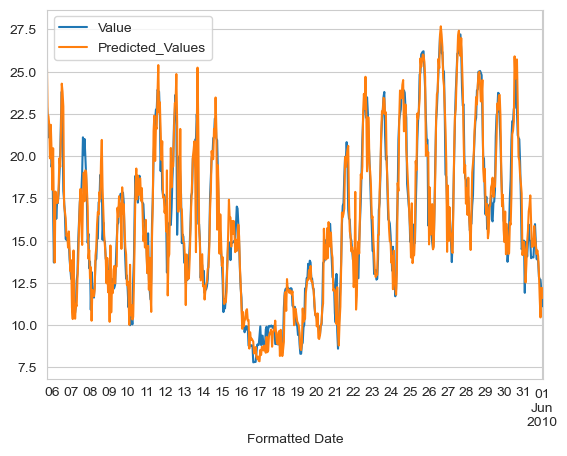

In [221]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()

In [224]:
from sklearn.metrics import r2_score, mean_squared_error

median_value = df_c['Predicted_Values'].median()
df_c['Predicted_Values'].fillna(median_value, inplace=True)

# Вычислить R^2
r2 = r2_score(df_c.Value, df_c.Predicted_Values)

# Вычислить MSE
mse = mean_squared_error(df_c.Value, df_c.Predicted_Values)

print("R^2:", r2)
print("MSE:", mse)

R^2: 0.8927016745685903
MSE: 2.3370915454448196
